In [23]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## Imports:
Here we import: 
* Keras to create our neural network
* pandas and pandas_data reader to get and analyze our stock data
* datetime to fix our stock dates for data analysis 
* numpy to reshape our data to feed into our neural network 
* matplotlib to plot and visualize our data 
* warnings to ignore any of the unwanted warnings that pop up 

In [24]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
# start = datetime.datetime(2014,1,1)
# end = datetime.datetime(2018,12,30)
data = pd.read_csv('historic_data/csv/TCS.NS.csv')
df = data.loc[:4130].dropna(how='any', axis=0)
test_df = data.loc[4131:].dropna(how='any', axis=0)

df = df.dropna(how='any', axis=0)


df.tail()



,Date,Low,Open,Volume,High,Close,Adjusted Close
4126,28-02-2019,1977.599976,2060.000000,8454295.0,2071.350098,1983.449951,1805.982178
4127,01-03-2019,1980.349976,1995.050049,4148548.0,2005.000000,1995.400024,1816.862793
4128,05-03-2019,1976.599976,2005.000000,2449622.0,2007.000000,1988.099976,1810.215942
4129,06-03-2019,1985.050049,1989.300049,2635047.0,2015.000000,1999.599976,1820.687134
4130,07-03-2019,2000.199951,2005.000000,2539884.0,2024.050049,2013.300049,1833.161255


## Getting our stock data: 
* This code changes our plot style to ggplot. I changed the style to ggplot because I like the look of it. Read more about ggplot [here](https://matplotlib.org/3.1.1/gallery/style_sheets/ggplot.html). 
* We then use pandas_datareader as "web" to get our stock price data using the DataReader function which gets the finance data and stores it in a pandas dataframe. 
* We get the Tesla stock data from 2014-2018 to train our model on. 
* We get the Tesla stock data from 2019 to the current day to have our model make predictions on.
* "TSLA" is the stock ticker symbol for Tesla and we specify 'yahoo' to get the data using the Yahoo finance API.

In [25]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d-%m-%Y')
test_df['Date'] = test_df['Date'].dt.strftime('%Y-%m-%d')

#sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

test_df.tail()

,index,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,,
2023-03-17,5127,3144.000000,3150.500000,6739966.0,3221.399902,3179.300049,3179.300049
2023-03-20,5128,3095.050049,3169.649902,2289468.0,3169.649902,3143.300049,3143.300049
2023-03-21,5129,3097.449951,3143.300049,1815297.0,3156.750000,3106.100098,3106.100098
2023-03-22,5130,3106.100098,3130.050049,1123939.0,3143.500000,3130.800049,3130.800049
2023-03-23,5131,3101.000000,3114.899902,943746.0,3146.350098,3130.000000,3130.000000


## Fixing our data:
* Since we are doing a time series prediction we want our data to be sequential. We sort our train and test data by date. 
* We then reset the index and set the index of our dataframe to make sure the dates of our stock prices are a column in our dataframe 

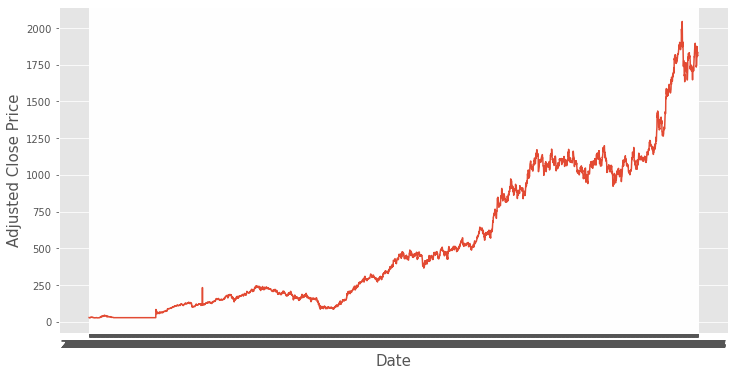

In [26]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adjusted Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

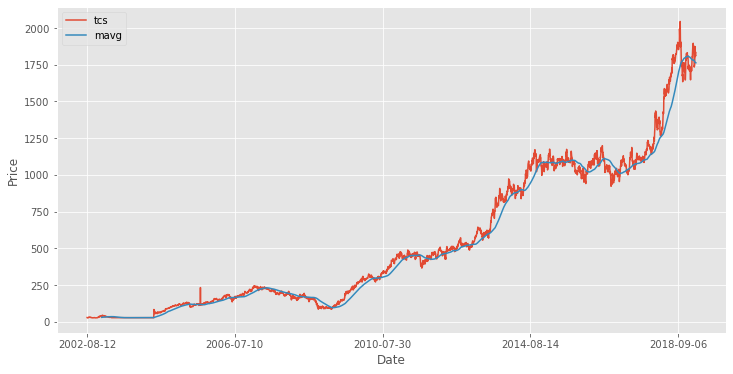

In [27]:
# Rolling mean
close_px = df['Adjusted Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='tcs')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## Rolling mean: 
* We get our adjusted closing prices from our dataframe and we plot a rolling mean on our data. 
* Rolling mean is also called moving average. Moving average helps us smooth out data that has lots of fluctuations and helps us better see the long term trend of the data.
* With moving average you can define a period of time you'd like to take the average of which is known as our window. We define our moving average window to be 100. We define 100 because we want to see the moving average over the long term in our data. 

#### The math: 
* The way moving average works is it sums the prices of 100 days in a row and divides by 100 to get the mean. Then we move our window to the right by one. So we drop the first price and add a new price to the end. 
* Another way to think of it is think of it as an array of 100 prices. We sum all the elements and divide by 100 to get our average. We then remove the element at ```a[0]``` append another price to the end of the array. We then sum all the elements again and then divide by 100 to get our next average point. 

In [28]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

dates_df['Date'] = pd.to_datetime(dates_df['Date'])


# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)
dates_df.head()
# dates_df.tail()

,Date,index,Low,Open,Volume,High,Close,Adjusted Close
0,11911.0,0,38.724998,38.724998,212976.0,40.000000,39.700001,28.485004
1,11912.0,1,38.875000,39.750000,153576.0,40.387501,39.162498,28.099331
2,11913.0,2,35.724998,39.250000,822776.0,39.250000,36.462502,26.162079
3,11914.0,3,36.462502,36.462502,0.0,36.462502,36.462502,26.162079
4,11915.0,4,35.750000,36.275002,811856.0,38.000000,36.375000,26.099285


## Converting dates: 
* Here we create a copy of our dataframe and called it dates_df. We store our original dates in org_dates. We will use org_dates later to plot our predictions and dates. 
* We then convert our dates_df dates to integers by using mdates.date2num. We need the dates as integers because you can't feed dates into Support Vector Machines and neural networks. 

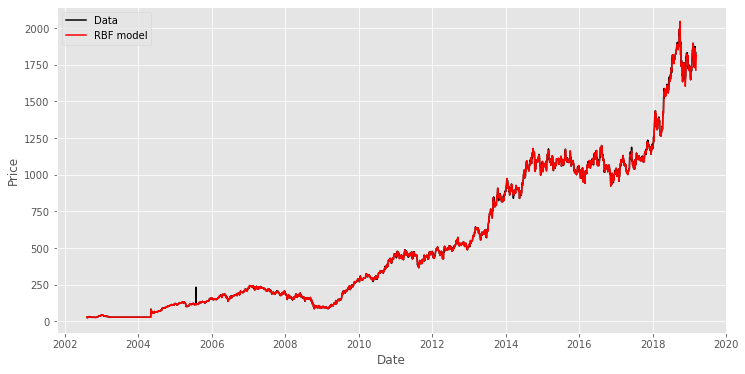

In [29]:
# Use sklearn support vector regression to predict our data:
from sklearn.svm import SVR

dates = dates_df['Date'].to_numpy()
prices = df['Adjusted Close'].to_numpy()

# Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize=(12, 6))
plt.plot(dates, prices, color='black', label='Data')
plt.plot(org_dates, svr_rbf.predict(dates), color='red', label='RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [30]:
train_data = df.iloc[:, df.columns.get_loc('Adjusted Close')].to_numpy()
print(train_data.shape)

(4122,)


In [31]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
print(train_data)
scaler.fit(train_data)
train_data = scaler.transform(train_data)


[[  28.48500443]
 [  28.0993309 ]
 [  26.16207886]
 ...
 [1810.21594238]
 [1820.68713379]
 [1833.16125488]]


## Normalizing: 
* Here we create our training data and normalize it. We use sklearn to create a MinMaxScaler() object. 
* MinMaxScaler works by shrinking the range of our values into 0 or 1 
* Below is the equation for min-max scaler: 
<img src="Images/MinMax.png">
* This is the equation that sklearn is doing in the background to convert our data into our desired range. 

In [32]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [33]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))



In [34]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[28.48500443]
 [28.0993309 ]
 [26.16207886]
 [26.16207886]
 [26.09928513]
 [25.45353317]
 [26.16207886]
 [27.4446125 ]
 [28.62849426]
 [30.35051537]
 [30.24290085]
 [29.48950577]
 [29.51639938]
 [29.51639938]
 [31.60614014]
 [31.92901611]
 [30.43123627]
 [31.09492683]
 [30.90655899]
 [29.75856972]
 [29.37290764]
 [29.37290764]
 [30.11732292]
 [30.26979256]
 [29.40878868]
 [28.83478165]
 [29.677845  ]
 [28.7630291 ]
 [28.52087212]
 [28.05449104]
 [27.57914352]
 [26.64638519]
 [26.85267448]
 [27.27420998]
 [27.60604858]
 [26.60153961]]


y_train: [[26.37733078]]



## Preparing our data for the neural network: 
* Here we create the 'create_dataset' function. This function loops from (0 to our dataset length - the number of time steps). 
* So essentially each index in the X_train array contains an array of 36 days of closing prices and the y_train array contains the closing price one day after our time steps. 
* So, in other words, we feed the neural network 36 days of the previous closing prices of stock data and then have it predict the next day of the closing stock price. 

In [35]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 50, batch_size = 10, validation_split=.30)

Epoch 1/50
286/286 [==============================] - 16s 36ms/step - loss: 5.7943e-04 - val_loss: 6.8541e-04
Epoch 2/50
286/286 [==============================] - 10s 36ms/step - loss: 2.1816e-04 - val_loss: 0.0013
Epoch 3/50
286/286 [==============================] - 10s 37ms/step - loss: 1.7884e-04 - val_loss: 0.0036
Epoch 4/50
286/286 [==============================] - 10s 35ms/step - loss: 1.5835e-04 - val_loss: 3.6761e-04
Epoch 5/50
286/286 [==============================] - 10s 33ms/step - loss: 1.6737e-04 - val_loss: 0.0012
Epoch 6/50
286/286 [==============================] - 10s 35ms/step - loss: 1.3244e-04 - val_loss: 4.2864e-04
Epoch 7/50
286/286 [==============================] - 10s 34ms/step - loss: 1.3102e-04 - val_loss: 3.0152e-04
Epoch 8/50
286/286 [==============================] - 10s 35ms/step - loss: 1.2989e-04 - val_loss: 0.0018
Epoch 9/50
286/286 [==============================] - 10s 36ms/step - loss: 1.1665e-04 - val_loss: 7.5727e-04
Epoch 10/50
286/286 [=====

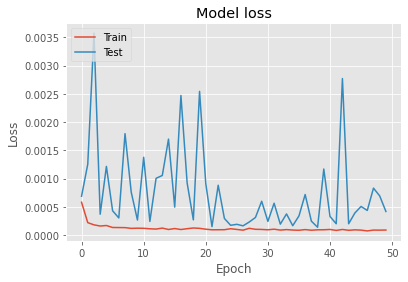

In [36]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adjusted Close'].values
print(test_data)
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

[1841.72021484 1834.52685547 1832.38720703 ... 3106.10009766 3130.80004883
 3130.        ]
31/31 [==============================] - 2s 18ms/step


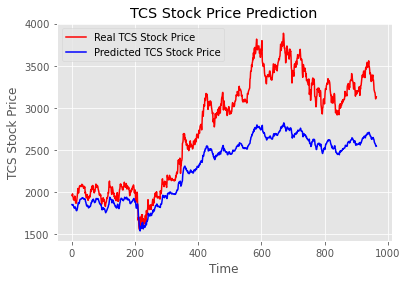

In [39]:
plt.plot(org_y, color = 'red', label = 'Real TCS Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted TCS Stock Price')
plt.title('TCS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TCS Stock Price')

plt.legend()
plt.show()
